# affine-invariant MCMC package testing (Julia)

In [2]:
using Plots
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf
using Distributed
import Random: seed!, randn
include("AffineInvariantMCMC.jl")

save_chain (generic function with 1 method)

In [3]:
Threads.nthreads()

4

In [4]:
nprocs()

1

# Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [5]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [6]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [7]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 10000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

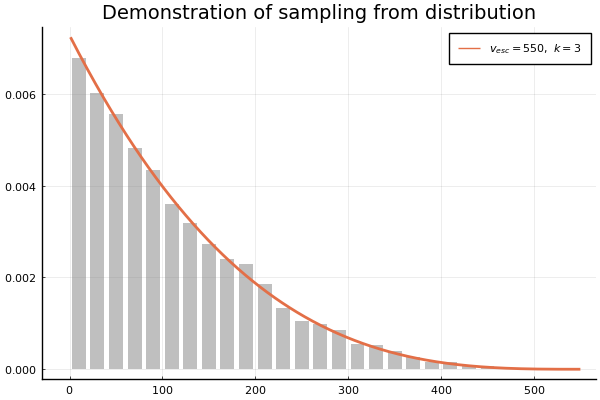

In [8]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

# Define MCMC functions and parameters

In [9]:
function log_prior(x)
    vesc,k = x
    if 100.0 < vesc < 800.0 && 0.2 < k < 10.0 
        return 0.0
    end

    return -Inf
end

function log_likelihood(x,data)
    vesc,k = x
    sum = 0.0
    for v in data
        #println("v = ",v,", vesc = ",vesc)
        if v < vesc
            sum += log(k+1.0) - (k+1.0)*log(vesc) + k*log(vesc - v)
        else
            return -Inf 
        end
    end
    return sum
end

function log_probability(x,data)
    return log_likelihood(x,data) + log_prior(x)
end

log_probability (generic function with 1 method)

# Use MCJulia to perform sampling

### Parameters and initial conditions for walkers

In [10]:
# Parameters
ndims = 2
nwalkers = 10
nsamples_perwalker = 4000
burnin = 200
a = 2.0     # affine-invariant MCMC scale parameter (see http://msp.org/camcos/2010/5-1/p04.xhtml) 
thin = 1

# ICs
guess_vesc = 600
guess_k = 4

initial_guess_dist = MvNormal([0.0,0.0],[90 0.0 ; 0.0 0.9])

initial_guess_onewalker = [guess_vesc,guess_k]
initial_guess = copy(transpose(reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ) )
#initial_guess = reshape( reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ,
#                         (nwalkers,ndims))

quantile_list = [0.16, 0.5, 0.84];


In [11]:
seed!(0)
S = Sampler(nwalkers, ndims, log_probability, a, (target_data,));

In [12]:
burnin_final_state = sample(S, initial_guess, burnin,thin,false)

Starting multi-threaded sampling...


10×2 Matrix{Float64}:
 542.361  2.88435
 551.724  2.94588
 547.038  2.93222
 536.186  2.7738
 548.422  2.87774
 560.375  3.03211
 561.954  3.05171
 543.496  2.86573
 548.54   2.90061
 553.015  3.00793

In [13]:
@btime sample(S, burnin_final_state, nsamples_perwalker, 5, true)  # (sampler, starting point, number of steps, thinning factor for data, store chain?)
println("acceptance ratio: $(S.accepted / S.iterations)")

Starting multi-threaded sampling...
Starting multi-threaded sampling...
Starting multi-threaded sampling...
Starting multi-threaded sampling...
Starting multi-threaded sampling...
Starting multi-threaded sampling...
Starting multi-threaded sampling...
  2.547 s (503095 allocations: 21.66 MiB)
acceptance ratio: 0.7262086333487036


In [14]:
vesc_posterior = flat_chain(S)[1,:];
k_posterior = flat_chain(S)[2,:];

deleteat!(vesc_posterior, vesc_posterior .== 0.0);
deleteat!(k_posterior, k_posterior .== 0.0);

### Process the data

In [15]:
# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

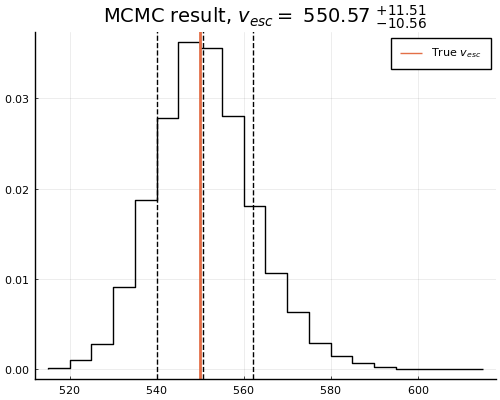

In [16]:
plot(vesc_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{-$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

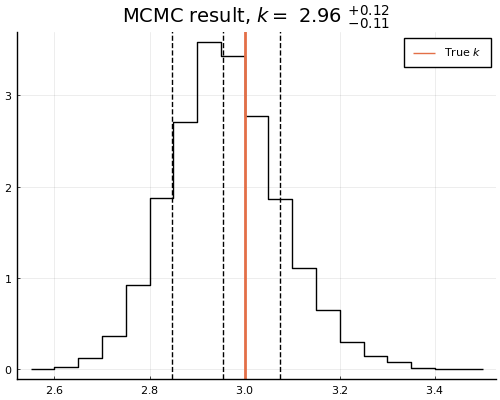

In [17]:
plot(k_posterior, normed = true,
                    bins = 25,
                    title = "MCMC result, \$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{-$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")